In [2]:
from sklearn.decomposition import TruncatedSVD
import time
from scipy.sparse.linalg import svds
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
import pickle

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# 데이터 불러오기
def load_data():
    # result = get_player_prev_solo_rank()
    # score_data = pd.json_normalize(result)
    score_data = pd.read_csv('data/score_data.csv')
    champ_data = pd.read_csv('data/champ_data.csv')
    return score_data, champ_data

# 데이터 전처리
def preprocess_data(score_data):
    # 피벗테이블 형태로 만들기
    user_champ_score = score_data.pivot(
        index='user_id',
        columns='champion',
        values='score'
    ).fillna(0)

    # champ_user_score = user_champ_score.T.to_numpy()

    matrix = user_champ_score.to_numpy()

    # 정규화
    # 유저의 평균 Score(영화의 별점)을 각 유저의 score에서 감산
    user_scores_mean = np.mean(matrix, axis = 1)

    matrix_user_mean = matrix - user_scores_mean.reshape(-1, 1)

    start_time = time.time()
    norm_matrix_user_mean = normalize(matrix_user_mean, axis=1, norm='l2')
    end_time = time.time()
    print(f"Normalization took {end_time - start_time:.4f} seconds")

    return norm_matrix_user_mean, matrix_user_mean, user_champ_score

def SVD(matrix_user_mean, user_champ_score):
    # svd(특이값 분해) 모델링 부분
    U, sigma, Vt = svds(matrix_user_mean, k = 100)
    # sigma는 0이 아닌 특이값의 나열(1차원 행렬)으로(sigma.shape (12,)), 0이 포함된 대칭행렬을 사용하기 위해 np.diag 적용(12,12)
    sigma = np.diag(sigma)

    # U, Sigma, Vt의 내적을 수행하면, 다시 원본 행렬로 복원이 된다. 
    # 거기에 + 사용자 평균 rating을 적용한다.
     
    # svd_user_predicted_scores = np.dot(np.dot(U, sigma), Vt) + user_scores_mean.reshape(-1, 1)
    svd_user_predicted_scores = np.dot(np.dot(U, sigma), Vt)
    # df_svd_preds = pd.DataFrame(svd_user_predicted_scores, columns = user_champ_score.columns)
    return pd.DataFrame(svd_user_predicted_scores, columns = user_champ_score.columns)

if __name__ == "__main__":
    score_data, champ_data = load_data()
    norm_matrix_user_mean, matrix_user_mean, user_champ_score = preprocess_data(score_data)
    df_svd_preds = SVD(matrix_user_mean, user_champ_score)
    # 데이터를 pickle 파일로 저장
    print(df_svd_preds.shape)
    print(norm_matrix_user_mean.shape)
    with open('models/df_svd_preds.pkl', 'wb') as f:
        pickle.dump(df_svd_preds, f)
    with open('models/norm_matrix_user_mean.pkl', 'wb') as f:
        pickle.dump(norm_matrix_user_mean, f) 


Normalization took 0.2206 seconds
(338710, 167)
(338710, 167)


In [3]:
score_data, champ_data = load_data()
display(score_data)

,user_id,champion,score
0,203,Kled,30.24
1,208,Rell,25.97
2,208,Syndra,7.92
3,213,Warwick,43.68
4,213,Nautilus,7.93
...,...,...,...
760257,31044,Lux,12.00
760258,31062,Yasuo,17.85
760259,31062,Yone,3.90
760260,31064,Orianna,14.96


In [4]:
pd.options.display.max_rows = 60

In [5]:
pd.options.display.max_columns = 167
display(user_champ_score)

champion,Aatrox,Ahri,Akali,Akshan,Alistar,Amumu,Anivia,Annie,Aphelios,Ashe,AurelionSol,Azir,Bard,Belveth,Blitzcrank,Brand,Braum,Briar,Caitlyn,Camille,Cassiopeia,Chogath,Corki,Darius,Diana,DrMundo,Draven,Ekko,Elise,Evelynn,Ezreal,Fiddlesticks,Fiora,Fizz,Galio,Gangplank,Garen,Gnar,Gragas,Graves,Gwen,Hecarim,Heimerdinger,Hwei,Illaoi,Irelia,Ivern,Janna,JarvanIV,Jax,Jayce,Jhin,Jinx,KSante,Kaisa,Kalista,Karma,Karthus,Kassadin,Katarina,Kayle,Kayn,Kennen,Khazix,Kindred,Kled,KogMaw,Leblanc,LeeSin,Leona,Lillia,Lissandra,Lucian,Lulu,Lux,Malphite,Malzahar,Maokai,MasterYi,Milio,MissFortune,MonkeyKing,Mordekaiser,Morgana,Naafiri,Nami,Nasus,Nautilus,Neeko,Nidalee,Nilah,Nocturne,Nunu,Olaf,Orianna,Ornn,Pantheon,Poppy,Pyke,Qiyana,Quinn,Rakan,Rammus,RekSai,Rell,Renata,Renekton,Rengar,Riven,Rumble,Ryze,Samira,Sejuani,Senna,Seraphine,Sett,Shaco,Shen,Shyvana,Singed,Sion,Sivir,Skarner,Smolder,Sona,Soraka,Swain,Sylas,Syndra,TahmKench,Taliyah,Talon,Taric,Teemo,Thresh,Tristana,Trundle,Tryndamere,TwistedFate,Twitch,Udyr,Urgot,Varus,Vayne,Veigar,Velkoz,Vex,Vi,Viego,Viktor,Vladimir,Volibear,Warwick,Xayah,Xerath,XinZhao,Yasuo,Yone,Yorick,Yuumi,Zac,Zed,Zeri,Ziggs,Zilean,Zoe,Zyra
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,12.76,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.00
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.96,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,11.88,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,5.04,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,6.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,10.88,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [6]:
import sys
user_champ_score = score_data.pivot(
        index='user_id',
        columns='champion',
        values='score'
    ).fillna(0)
sorted_pivot_table = user_champ_score.sort_values(by=('Kled'), ascending=False)
user_3248_scores = user_champ_score.loc[398222].to_numpy()
pd.options.display.max_columns = 167
np.set_printoptions(threshold=sys.maxsize)
thirtieth_user_id = user_champ_score.index[1]
display(user_3248_scores)


array([ 7.92,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  , 10.92,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        6.93,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,

In [7]:
matrix = user_champ_score.to_numpy()

In [8]:
    # 정규화
    # 유저의 평균 Score(영화의 별점)을 각 유저의 score에서 감산
user_scores_mean = np.mean(matrix, axis = 1)

matrix_user_mean = matrix - user_scores_mean.reshape(-1, 1)

In [11]:
U, sigma, Vt = svds(matrix_user_mean, k= 30)

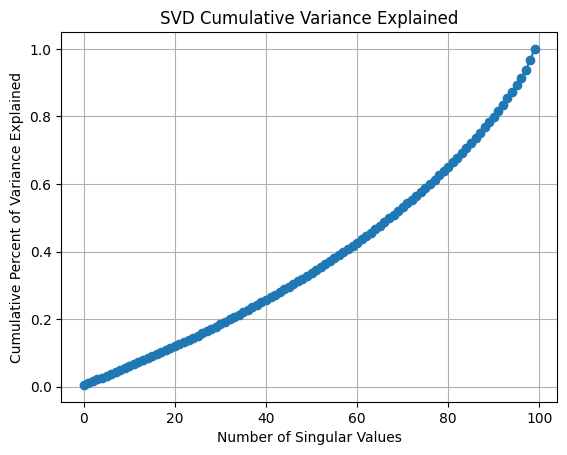

In [52]:
import numpy as np
import matplotlib.pyplot as plt
# 예를 들어, sigma가 SVD에서 얻은 특이값의 배열이라고 가정합니다.
# sigma = np.array([값들...])

# 각 특이값의 제곱을 전체 분산으로 나누어 각 특이값이 전체 분산에서 차지하는 비율을 계산합니다.
variance_ratios = sigma**2 / np.sum(sigma**2)

# 누적 분산 설명 비율을 계산합니다.
cumulative_variance_ratios = np.cumsum(variance_ratios)

# 누적 분산 설명 비율을 그래프로 표현합니다.
plt.plot(cumulative_variance_ratios, marker='o', linestyle='-')
plt.xlabel('Number of Singular Values')
plt.ylabel('Cumulative Percent of Variance Explained')
plt.title('SVD Cumulative Variance Explained')
plt.grid(True)
plt.show()


In [12]:
pd.DataFrame(matrix_user_mean, columns = user_champ_score.columns).head()

champion,Aatrox,Ahri,Akali,Akshan,Alistar,Amumu,Anivia,Annie,Aphelios,Ashe,AurelionSol,Azir,Bard,Belveth,Blitzcrank,Brand,Braum,Briar,Caitlyn,Camille,Cassiopeia,Chogath,Corki,Darius,Diana,DrMundo,Draven,Ekko,Elise,Evelynn,Ezreal,Fiddlesticks,Fiora,Fizz,Galio,Gangplank,Garen,Gnar,Gragas,Graves,Gwen,Hecarim,Heimerdinger,Hwei,Illaoi,Irelia,Ivern,Janna,JarvanIV,Jax,Jayce,Jhin,Jinx,KSante,Kaisa,Kalista,Karma,Karthus,Kassadin,Katarina,Kayle,Kayn,Kennen,Khazix,Kindred,Kled,KogMaw,Leblanc,LeeSin,Leona,Lillia,Lissandra,Lucian,Lulu,Lux,Malphite,Malzahar,Maokai,MasterYi,Milio,MissFortune,MonkeyKing,Mordekaiser,Morgana,Naafiri,Nami,Nasus,Nautilus,Neeko,Nidalee,Nilah,Nocturne,Nunu,Olaf,Orianna,Ornn,Pantheon,Poppy,Pyke,Qiyana,Quinn,Rakan,Rammus,RekSai,Rell,Renata,Renekton,Rengar,Riven,Rumble,Ryze,Samira,Sejuani,Senna,Seraphine,Sett,Shaco,Shen,Shyvana,Singed,Sion,Sivir,Skarner,Smolder,Sona,Soraka,Swain,Sylas,Syndra,TahmKench,Taliyah,Talon,Taric,Teemo,Thresh,Tristana,Trundle,Tryndamere,TwistedFate,Twitch,Udyr,Urgot,Varus,Vayne,Veigar,Velkoz,Vex,Vi,Viego,Viktor,Vladimir,Volibear,Warwick,Xayah,Xerath,XinZhao,Yasuo,Yone,Yorick,Yuumi,Zac,Zed,Zeri,Ziggs,Zilean,Zoe,Zyra
0,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,12.629701,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,-0.130299,8.869701
1,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,-0.124790,8.835210,-0.124790,-0.124790,-

In [43]:
print(U.shape)
print(sigma.shape)
print(Vt.shape)

(338710, 30)
(30, 30)
(30, 167)


In [45]:
sigma = np.diag(sigma)

    # U, Sigma, Vt의 내적을 수행하면, 다시 원본 행렬로 복원이 된다. 
    # 거기에 + 사용자 평균 rating을 적용한다.
     
    # svd_user_predicted_scores = np.dot(np.dot(U, sigma), Vt) + user_scores_mean.reshape(-1, 1)
svd_user_predicted_scores = np.dot(np.dot(U, sigma), Vt)
df_svd_preds = pd.DataFrame(svd_user_predicted_scores, columns = user_champ_score.columns)

In [97]:
user_index = 306
user_id = 435
user_row_number = user_index

In [98]:
sorted_user_predictions = df_svd_preds.iloc[user_row_number].sort_values(ascending=False)
user_data = score_data[score_data.user_id == user_id]
user_history = pd.merge(user_data, champ_data, left_on='champion', right_on='id', how='inner').sort_values(['score'], ascending=False)
user_history.drop(columns=['name'], inplace=True)
recommendations = champ_data[~champ_data['id'].isin(user_history['champion'])]
recommendations = pd.merge(recommendations, sorted_user_predictions, left_on='id', right_on='champion', how='inner')
display(sorted_user_predictions)
display(user_history)
display(recommendations)

champion
Jhin           15.711420
Caitlyn         0.934837
Jinx            0.531917
Lucian          0.527936
Varus           0.517972
                 ...    
Nautilus       -0.266879
Pyke           -0.314915
MissFortune    -0.422354
Ezreal         -0.750084
Smolder        -0.822225
Name: 306, Length: 167, dtype: float64

,user_id,champion,score,id,difficulty
0,435,Jhin,16.1,Jhin,6


,id,name,difficulty,306
0,Aatrox,아트록스,4,0.002416
1,Ahri,아리,5,-0.169485
2,Akali,아칼리,7,-0.131703
3,Akshan,아크샨,6,-0.169888
4,Alistar,알리스타,7,-0.138113
...,...,...,...,...
161,Zeri,제리,6,-0.136271
162,Ziggs,직스,4,-0.102054
163,Zilean,질리언,6,-0.112244
164,Zoe,조이,5,-0.118802


In [99]:
tier = 'Challenger'
recommendations = recommendations.rename(columns = {user_row_number: 'Predictions'}).sort_values('Predictions', ascending = False).iloc[:20, :]
display(recommendations)

if tier in ['Iron', 'Bronze', 'Silver']:
   conditions = [
        recommendations['difficulty'] >= 7,
        recommendations['difficulty'] >= 5,
        recommendations['difficulty'] >= 4
    ] 
   values = [
        recommendations['Predictions'] * 0.6,
        recommendations['Predictions'] * 0.8,
        recommendations['Predictions'] * 1.0
    ]
   default = recommendations['Predictions'] * 1.3
elif tier in ['Gold', 'Platinum']:
   conditions = [
        recommendations['difficulty'] >= 8,
        recommendations['difficulty'] >= 7
    ] 
   values = [
        recommendations['Predictions'] * 0.7,
        recommendations['Predictions'] * 0.8
    ]
   default = recommendations['Predictions'] * 1.0
elif tier in ['Emerald', 'Diamond']:
   conditions = [
        recommendations['difficulty'] >= 9
    ] 
   values = [
        recommendations['Predictions'] * 0.8
    ]
   default = recommendations['Predictions'] * 1.0
else:
   conditions = [
        recommendations['difficulty'] >= 9,
        recommendations['difficulty'] >= 8
    ] 
   values = [
        recommendations['Predictions'] * 1.3,
        recommendations['Predictions'] * 1.2
    ]
   default = recommendations['Predictions'] * 1.0

recommendations['Predictions'] = np.select(conditions, values, default=default)
display(recommendations)

,id,name,difficulty,Predictions
18,Caitlyn,케이틀린,6,0.934837
51,Jinx,징크스,6,0.531917
71,Lucian,루시안,6,0.527936
141,Varus,바루스,2,0.517972
9,Ashe,애쉬,4,0.444603
52,Kaisa,카이사,6,0.379033
137,TwistedFate,트위스티드 페이트,9,0.256711
112,Senna,세나,7,0.155858
43,Hwei,흐웨이,9,0.124445
132,Teemo,티모,6,0.119108


,id,name,difficulty,Predictions
18,Caitlyn,케이틀린,6,0.747870
51,Jinx,징크스,6,0.425534
71,Lucian,루시안,6,0.422348
141,Varus,바루스,2,0.673364
9,Ashe,애쉬,4,0.444603
52,Kaisa,카이사,6,0.303226
137,TwistedFate,트위스티드 페이트,9,0.154026
112,Senna,세나,7,0.093515
43,Hwei,흐웨이,9,0.074667
132,Teemo,티모,6,0.095286
